## 0. 导入依赖 (Import Dependencies)

**[Ablation Study: Only Value]**
这是一个消融实验 Notebook，旨在验证“仅使用数值信息 (Abundance Value)”对模型性能的影响。
在此配置中，我们将：
1. **关闭 Cross-Attention** (不使用先验知识库)
2. **关闭 Condition Embeddings** (不使用环境元数据)
3. 仅保留 **Species Embeddings** (物种 ID) + **Value Embeddings** (丰度等级)

In [1]:
import os
import torch
import warnings
from pickle import load
from argparse import Namespace
from configparser import ConfigParser
from importlib.resources import files

import pandas as pd
from torch.utils.data import Subset

from transformers import (
    Trainer,
    TrainingArguments,
)
from transformers.trainer_callback import EarlyStoppingCallback

# --- v2.0 新增模块 ---
from MiCoGPT.utils_vCross.model_vCross import MiCoGPTConfig, MiCoGPTForCausalLM
from MiCoGPT.utils_vCross.collator_vCross import MiCoGPTDataCollator

# 复用 v4 的工具函数
from MiCoGPT.utils.tools import split_train_val_by_project_stratified

warnings.filterwarnings("ignore")

## 1. 基本参数设置 (Basic Parameters)

注意：这里 `output` 和 `log` 路径已修改为 `_onlyValue` 后缀，以免覆盖主模型。

In [2]:
args = Namespace(
    # 语料库文件路径
    input="../data/vCross/ResMicroDB_90338_vCross.pkl",
    
    # [Ablation] 修改输出路径，区分实验
    output="../models/pretrain_vCross_onlyValue",
    log="../logs/pretrain_vCross_onlyValue",
    
    # [Ablation] 不需要 prior_npz，设为 None
    prior_npz=None
)

# 验证集比例
VAL_RATIO = 0.10

## 2. 载入语料库 (Load Corpus)

载入数据，并提取必要的维度信息。

In [3]:
print(f"Loading corpus from {args.input} ...")
all_corpus = load(open(args.input, "rb"))

# 检查是否包含了 metadata 和 encoders
if not hasattr(all_corpus, "meta_encoders") or not all_corpus.meta_encoders:
    print("[Warning] Corpus object does not contain meta_encoders. Please check if it was constructed correctly.")

# 选择 Split_Group 为 A 的样本进行训练
if all_corpus.metadata is not None and "Split_Group" in all_corpus.metadata.columns:
    print("Subsetting corpus by Split_Group == 'A'...")
    corpus = all_corpus.subset_by_metadata(lambda df: df["Split_Group"] == "A")
else:
    print("Using full corpus (no Split_Group found or metadata missing).")
    corpus = all_corpus
    
tokenizer = all_corpus.tokenizer

print("Number of samples in all_corpus:", len(all_corpus))
print("Number of samples in corpus (Training subset):", len(corpus))
print("Tokenizer vocab size:", tokenizer.vocab_size)

Loading corpus from ../data/vCross/ResMicroDB_90338_vCross.pkl ...
Subsetting corpus by Split_Group == 'A'...
[subset_by_metadata] Selected 74557 samples out of 90338.
Number of samples in all_corpus: 90338
Number of samples in corpus (Training subset): 74557
Tokenizer vocab size: 1121


## 3. 构建消融模型 (Build Ablation Model)

关键修改：
1. `add_cross_attention=False`: 关闭先验知识注入。
2. `condition_vocab_sizes=[]`: 告诉模型没有环境元数据列。
3. `prior_matrix_path=None`: 不加载先验矩阵。

In [4]:
# 基础配置读取
cfg = ConfigParser()
cfg.read(files("MiCoGPT")/"resources/config.ini")

# 1. 构建配置
gpt2_config_dict = {
    "vocab_size":   tokenizer.vocab_size,
    "n_positions":  cfg.getint("GPT2", "n_positions"),
    "n_embd":       cfg.getint("GPT2", "n_embd"),
    "n_layer":      cfg.getint("GPT2", "n_layer"),
    "n_head":       cfg.getint("GPT2", "n_head"),
    "bos_token_id": tokenizer.bos_token_id,
    "eos_token_id": tokenizer.eos_token_id,
    "pad_token_id": tokenizer.pad_token_id,
}

config = MiCoGPTConfig(
    num_bins=52,                        # 保留 Value Embedding
    
    # [Ablation] 关闭 Condition Embeddings
    condition_vocab_sizes=[], 
    
    # [Ablation] 不使用 Prior Matrix
    prior_matrix_path=None,
    
    # [Ablation] 显式关闭 Cross-Attention
    add_cross_attention=False,
    
    **gpt2_config_dict
)

# 2. 实例化模型
model = MiCoGPTForCausalLM(config)

print("Model Config:", config)
print("Model Architecture:", model)
print("\n[Check] Cross Attention is:", "ENABLED" if config.add_cross_attention else "DISABLED")
print("[Check] Condition Embeddings:", len(model.condition_embeddings))

Model Config: MiCoGPTConfig {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "attn_pdrop": 0.1,
  "bos_token_id": 2,
  "condition_vocab_sizes": [],
  "embd_pdrop": 0.1,
  "eos_token_id": 3,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 256,
  "n_head": 8,
  "n_inner": null,
  "n_layer": 8,
  "n_positions": 512,
  "num_bins": 52,
  "pad_token_id": 0,
  "prior_matrix_path": null,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.33.3",
  "use_cache": true,
  "vocab_size": 1121
}

Model Architecture: MiCoGPTForCausalLM(
  (transformer): GPT2Model(
    (wte): Embedding(1121, 256)
    (wpe): Embedding(512, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (

## 4. 初始化数据整理器 (Data Collator)

注意：虽然我们关闭了 Condition Embeddings，但 Collator 还是会生成 `condition_ids`。
不过没关系，只要 Config 里设了 `condition_vocab_sizes=[]`，模型就不会去使用这些数据。

In [5]:
collator = MiCoGPTDataCollator(
    tokenizer=tokenizer,
    max_length=config.n_positions
)

## 5. 划分训练集和验证集 (Split Train/Val)

In [6]:
# 获取 metadata (兼容 Subset)
if isinstance(corpus, Subset):
    metadata = corpus.dataset.metadata
else:
    metadata = corpus.metadata

# 检查是否可以按 Project_ID 分层
if metadata is not None and "Project_ID" in metadata.columns:
    print("Using stratified split by Project_ID...")
    train_dataset, val_dataset = split_train_val_by_project_stratified(
        corpus,
        val_ratio=VAL_RATIO,
        project_col="Project_ID"
    )
else:
    print("Project_ID not found or metadata missing. Using random split...")
    val_size = int(len(corpus) * VAL_RATIO)
    train_size = len(corpus) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        corpus, [train_size, val_size], generator=torch.Generator().manual_seed(42)
    )

Using stratified split by Project_ID...
[split] total_samples=74557, target_val~7456
[split] eligible_projects=304, eligible_samples=74367
[split] ineligible_projects=16, ineligible_samples=190
[split] actual_val=7456 (target~7456), train=67101


## 6. 训练参数 (Training Arguments)

与主实验保持一致，除了 output_dir。

In [7]:
training_args = TrainingArguments(
    output_dir=f"{args.output}/checkpoints",
    overwrite_output_dir=True,
    num_train_epochs=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    
    learning_rate=1e-3,
    weight_decay=0.01,
    
    logging_dir=args.log,
    logging_steps=100,
    save_steps=500,
    eval_steps=500,
    evaluation_strategy="steps",
    save_strategy="steps",
    
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    
    # [NFS Fix] 
    dataloader_num_workers=0,
    dataloader_pin_memory=True,
    fp16=torch.cuda.is_available(),
    no_cuda=not torch.cuda.is_available(),
    
    report_to=["tensorboard"],
)

## 7. 开始训练 (Start Training)

In [8]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)],
)

trainer.train()

Step,Training Loss,Validation Loss
500,5.062800,4.812391
1000,4.881000,4.674445
1500,4.843800,4.600320
2000,4.767500,4.530615
2500,4.709100,4.466302
3000,4.680600,4.411077
3500,4.595200,4.356303
4000,4.533700,4.319857
4500,4.527500,4.281342
5000,4.497100,4.262774


TrainOutput(global_step=42500, training_loss=4.159472689998851, metrics={'train_runtime': 5005.9852, 'train_samples_per_second': 670.208, 'train_steps_per_second': 20.945, 'total_flos': 3.521008999858176e+16, 'train_loss': 4.159472689998851, 'epoch': 20.27})

## 8. 保存模型与日志 (Save)

In [ ]:
import json
import matplotlib.pyplot as plt

# 1. 保存模型
trainer.save_model(args.output)
tokenizer.save_pretrained(args.output)
print(f"Model saved to {args.output}")

# 2. 导出日志
log_history = trainer.state.log_history
log_path = f"{args.output}/training_logs.json"
with open(log_path, "w") as f:
    json.dump(log_history, f, indent=2)
print(f"Training logs saved to {log_path}")

# 3. 绘制曲线
train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]

plt.figure(figsize=(10, 6))
if train_steps:
    plt.plot(train_steps, train_loss, label="Training Loss", alpha=0.7)
if eval_steps:
    plt.plot(eval_steps, eval_loss, label="Validation Loss", marker="o", linestyle="--")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Ablation Study: Only Value (No Cross-Attn, No Condition)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.savefig(f"{args.output}/loss_curve.png")
print(f"Loss curve saved to {args.output}/loss_curve.png")
plt.show()

✅ Hotfix applied: 'save_vocabulary' method has been injected into the tokenizer.
Model and Tokenizer saved to ../models/pretrain_vCross_onlyValue


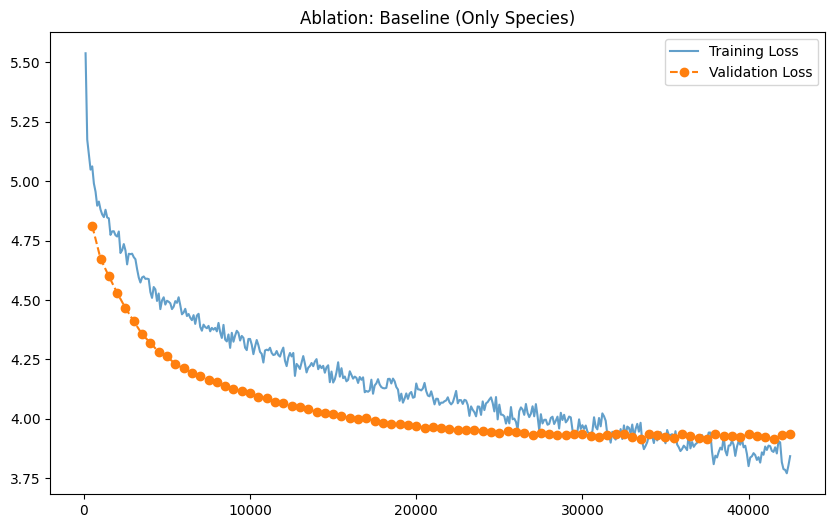

In [9]:
import os
import json
import types
import matplotlib.pyplot as plt

# --- 1. 临时补丁 (Hotfix) ---
# 在内存中定义缺失的 save_vocabulary 方法
def save_vocabulary_patch(self, save_directory: str, filename_prefix: str = None):
    if not os.path.isdir(save_directory):
        return
    
    vocab_file = os.path.join(
        save_directory, (filename_prefix + "-" if filename_prefix else "") + "vocab.json"
    )
    
    with open(vocab_file, "w", encoding="utf-8") as f:
        json.dump(self.vocab, f, ensure_ascii=False)
        
    return (vocab_file,)

# 将方法动态绑定到当前内存中的 tokenizer 类上
# 这样不需要重启内核，当前的 tokenizer 实例就能立刻拥有这个方法
tokenizer.__class__.save_vocabulary = save_vocabulary_patch
print("✅ Hotfix applied: 'save_vocabulary' method has been injected into the tokenizer.")

# --- 2. 执行保存与分析逻辑 ---

# 保存模型
trainer.save_model(args.output)
# 现在这一步应该能成功了，因为它会调用我们刚刚注入的 patch 方法
tokenizer.save_pretrained(args.output)
print(f"Model and Tokenizer saved to {args.output}")

# 导出日志
log_history = trainer.state.log_history
with open(f"{args.output}/training_logs.json", "w") as f:
    json.dump(log_history, f, indent=2)

# 绘制曲线
train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]

plt.figure(figsize=(10, 6))
if train_steps: plt.plot(train_steps, train_loss, label="Training Loss", alpha=0.7)
if eval_steps: plt.plot(eval_steps, eval_loss, label="Validation Loss", marker="o", linestyle="--")
plt.title("Ablation: Baseline (Only Species)")
plt.legend()
plt.savefig(f"{args.output}/loss_curve.png")
plt.show()